In [155]:
import numpy as np
from matplotlib import pyplot as plt
np.set_printoptions(suppress=True)
import os
import sys
import pickle
import json
sys.path.insert(0, "../")
sys.path.insert(0, "../../")
from matplotlib import image as mpimg
import torch
from scipy.stats import zscore
from rnn_coach.src.Task import TaskCDDM
from rnn_coach.src.RNN_torch import RNN_torch
from rnn_coach.src.RNN_numpy import RNN_numpy
from scipy.sparse.linalg import lsqr
from copy import deepcopy
from sklearn.decomposition import PCA

In [156]:
RNNs = []
for folder in os.listdir(os.path.join('../', "data", "inferred_LCs")):
    if (folder == "exemplar_RNN") or (folder == '.DS_Store') or (folder == '0.0077001_20230222-010124'):
        pass
    else:
        if "CDDM;relu" in folder:
#             if "lmbdo=0.3;lmbdr=0.0" in folder:
            RNNs.append(folder)

In [157]:
RNNs

['0.0070738_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0069802_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0066581_CDDM;relu;N=91;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0069969_CDDM;relu;N=92;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0073224_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0068477_CDDM;relu;N=88;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0065229_CDDM;relu;N=86;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0073745_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000',
 '0.0075082_CDDM;relu;N=88;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0068383_CDDM;relu;N=92;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0070615_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0073767_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.0067646_CDDM;relu;N=98;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000',
 '0.

0.0070738_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.8760089543290559
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


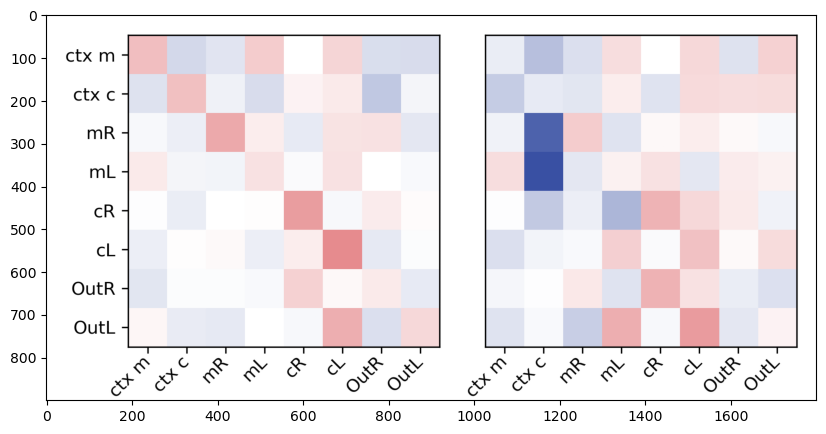

0.0069802_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.8866223057261717
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


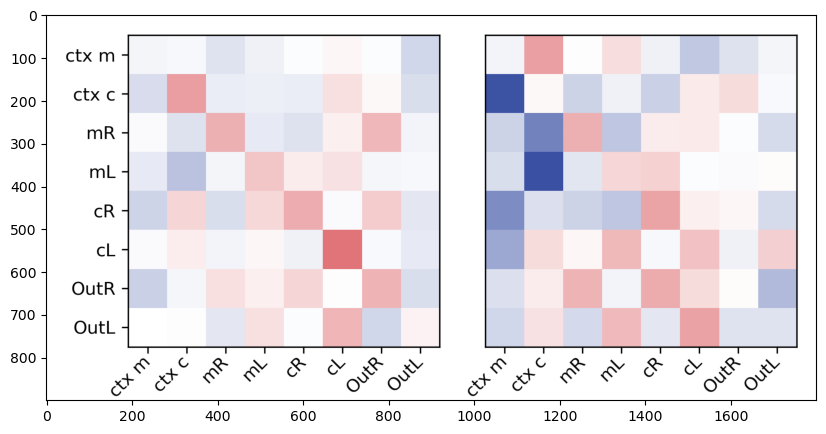

0.0066581_CDDM;relu;N=91;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.8996590591111734
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


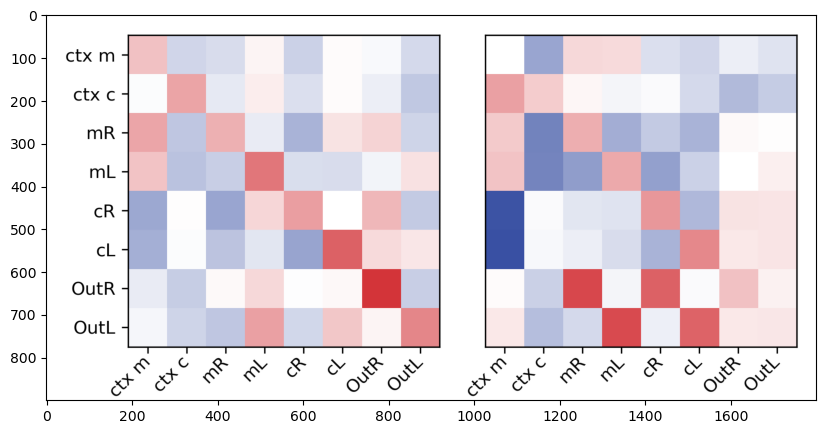

0.0069969_CDDM;relu;N=92;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.9089485972581353
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


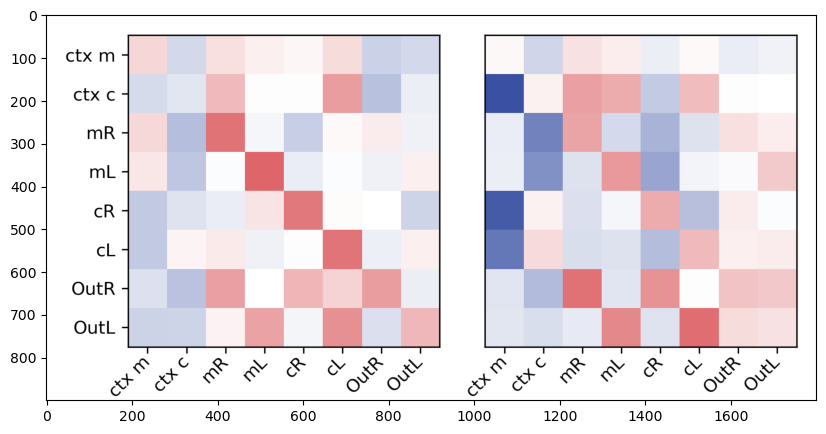

0.0073224_CDDM;relu;N=87;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.8836939521779112
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


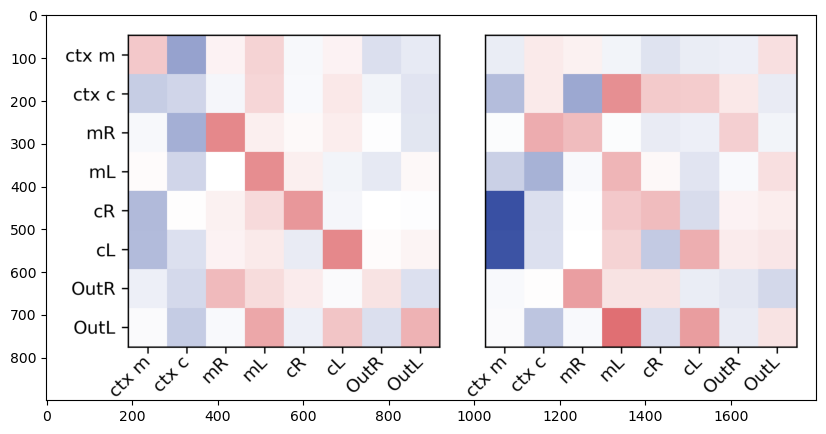

0.0068477_CDDM;relu;N=88;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.9031034735219029
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


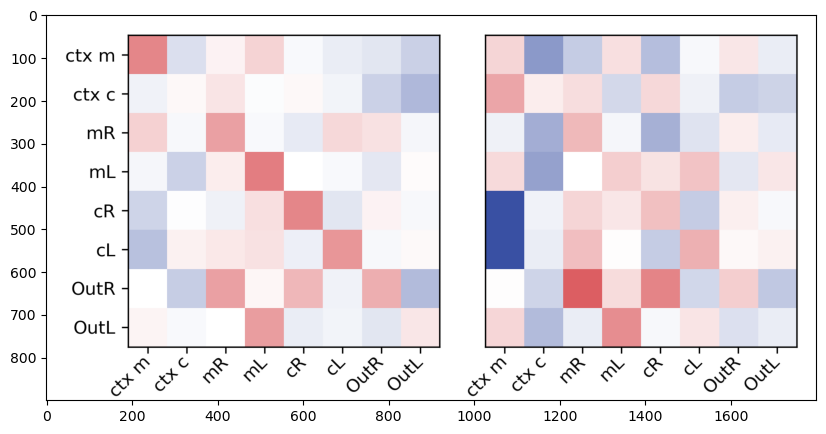

0.0065229_CDDM;relu;N=86;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.9084209773573962
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


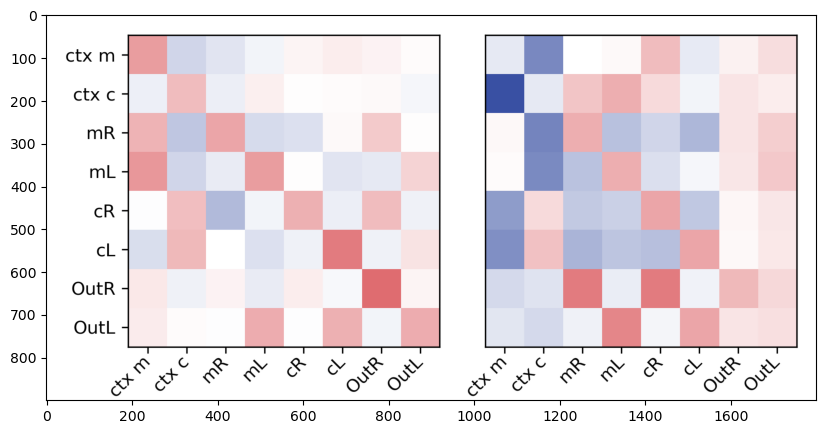

0.0073745_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000
0.91079138771519
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]


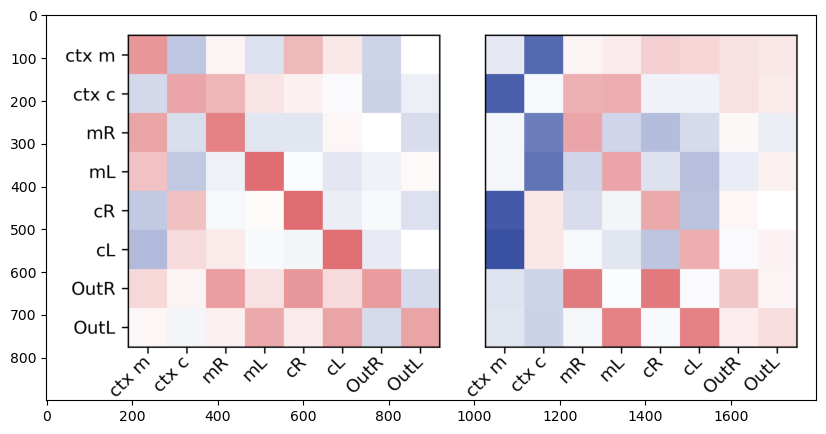

0.0075082_CDDM;relu;N=88;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000
0.8767805614989052
image:
[[[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 ...

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]

 [[1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  ...
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]
  [1. 1. 1. 1.]]]



KeyboardInterrupt



In [159]:
# first show the w_rec for the LCs
RNNs_filtered = []
max_scores = []
for RNN_folder in RNNs:
    RNN_score = float(RNN_folder.split("_")[0])
    RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
    LC_folder_path = os.path.join('../', "data", "inferred_LCs", RNN_folder)
    subfolders = os.listdir(LC_folder_path)
    ind = 0
    max_score = -10
    for i, subfolder in enumerate(subfolders):
        if "8nodes" in subfolder or '8-nodes' in subfolder:
            score = float(subfolder.split("_")[0])
            if max_score <= score:
                max_score = score
                ind = i 
    LC_subfolder = subfolders[ind]
    LC_path = os.path.join('../', "data", "inferred_LCs", RNN_folder, LC_subfolder)
    
    print(RNN_folder)
    print(max_score)
    max_scores.append(deepcopy(max_score))
    print("image:")
    fig = plt.figure(figsize=(10, 5))
    img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_wrec_comparison.png"), 'rb+'))
    plt.imshow(img)
    if max_score > 0.89:
        plt.savefig(os.path.join("../", "img", f"{RNN_folder}_conncomparison.png"))
        RNNs_filtered.append(RNN_folder)
    plt.show()


In [7]:
for i in np.where(np.array(max_scores) < 0.88)[0]:
    print(RNNs[i], max_scores[i])

0.0070738_CDDM;relu;N=90;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000 0.8760089543290559
0.0077001_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000 0.8654255019257225
0.0076561_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000 0.8398168700591474
0.0075358_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000 0.8697197981750155
0.0075082_CDDM;relu;N=88;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000 0.8767805614989052
0.0064612_CDDM;relu;N=92;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000 0.8770564523935152
0.0070526_CDDM;relu;N=88;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000 0.8706393538043021
0.0076043_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000 0.8648812689970811
0.0075352_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000 0.8552715442529989
0.0075855_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr=0.002;maxiter=3000 0.8582804801723607
0.0070801_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000 0.8755135565983744
0.0076407_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.1;lr

In [5]:
# list of good RNNs:
# CDDM_relu;N=100;lmbdr=0.0;lmbdo=0.3_0.0066983_20230403-220143

In [6]:
###### RNNs
#'0.0076407_20230222-025127' - color information is unsuppressed in motion context
# 0.0076407_20230222-025127 - both irrelevant stimuli are largely present
# 0.0076048_20230222-082312 - color information is somewhat unsuppressed in the motion context
# 0.0088791_20230221-232013 - color info in somewhat unsuppressed in motion context
# 0.0075352_20230222-063817 - motion is somewhat suppressed in the color context, color is definitely not suppressed in the motion context
# 0.0070184_20230222-083339 - color info is only partially suppressed 
# 0.0076561_20230222-083025 - color info definitely not suppressed in the motion context. However the motion info is suppressed
# 0.0076043_20230222-010348 - motion info is partially suppressed
# 0.0073745_20230222-064341 - motion info is partially suppressed
# 0.0075855_20230222-082806 - motion info is partially suppressed
# 0.0075358_20230222-063922 - motion info is partially suppressed


# CDDM_relu;N=100;lmbdr=0.0;lmbdo=0.3_0.0068963_20230403-202147
# CDDM_relu;N=100;lmbdr=0.0;lmbdo=0.3_0.0068341_20230403-201853

In [8]:
# RNN_folder = "0.0066983_CDDM;relu;N=89;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
# LC_folder = "CDDM_relu;N=100;lmbdr=0.0;lmbdo=0.3_0.0066983_20230403-220143"

RNN_folder = "0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
LC_folder = "0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000"
print(RNN_folder)
RNN_score = float(RNN_folder.split("_")[0])
RNN_path = os.path.join('../', '../', "rnn_coach", "data", "trained_RNNs", "CDDM", RNN_folder)
LC_folder_path = os.path.join('../', "data", "inferred_LCs", LC_folder)

0.0075283_CDDM;relu;N=100;lmbdo=0.3;lmbdr=0.0;lr=0.002;maxiter=3000


In [9]:
subfolders = os.listdir(LC_folder_path)
ind = 0
max_score = -10
for i, subfolder in enumerate(subfolders):
    if "8nodes" in subfolder or "8-nodes" in subfolder:
        score = float(subfolder.split("_")[0])
        if max_score <= score:
            max_score = score
            ind = i 
LC_subfolder = subfolders[ind]
LC_path = os.path.join('../', "data", "inferred_LCs", LC_folder, LC_subfolder)

In [10]:
max_score

0.9354187439243249

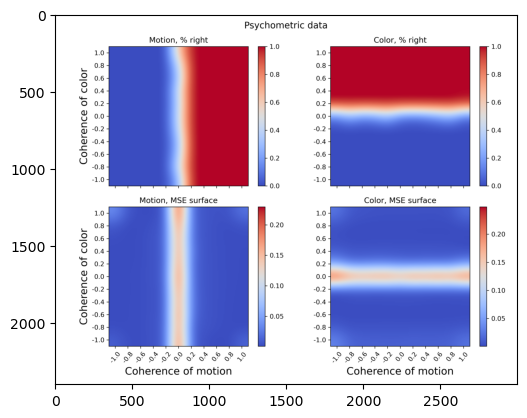

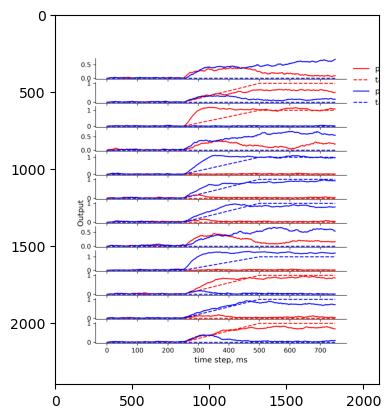

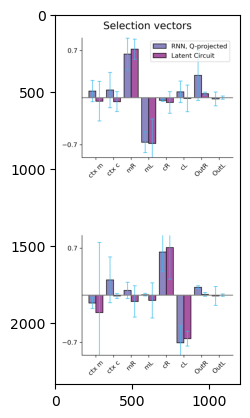

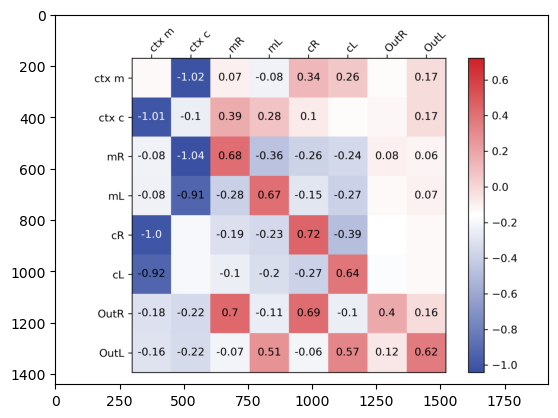

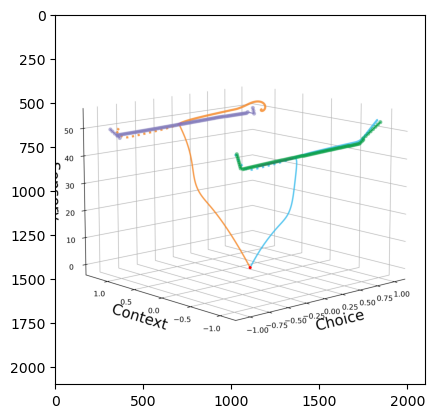

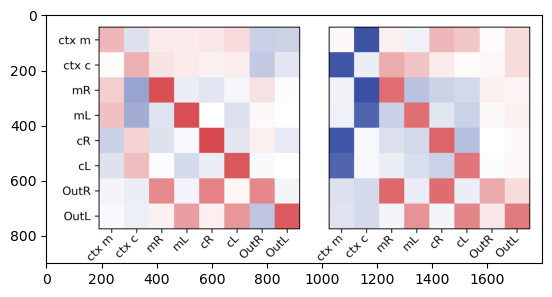

In [11]:
img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_psychometric.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_random_trials.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_selection_vects_comparison.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_wrec.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_LA3D.png"), 'rb+'))
plt.imshow(img)
plt.show()

img = mpimg.imread(open(os.path.join(LC_path, f"{max_score}_LC_wrec_comparison.png"), 'rb+'))
plt.imshow(img)
plt.show()

In [12]:
os.listdir(LC_path)

['0.0075283_params_CDDM.json',
 '0.9354187439243249_psycho_data.pkl',
 '0.0075283_1.0_LAdata_enhanced.pkl',
 '0.9354187439243249_LC_LA3D.png',
 '0.9354187439243249_LC_scores.json',
 '0.0075283_LAdata_corrupted.pkl',
 '0.9354187439243249_LC_params.json',
 '0.0075283_0.2_LAdata_corrupted.pkl',
 '0.9354187439243249_LC_psychometric.png',
 '0.0075283_config.json',
 '0.9354187439243249_selection_vects_comparison.png',
 '0.9354187439243249_LA_data.pkl',
 '0.9354187439243249_LC_random_trials.png',
 '0.9354187439243249_LC_wrec.png',
 '0.9354187439243249_LC_config.json',
 '0.0075283_0.2_LAdata_enhanced.pkl',
 '0.0075283_1.0_LAdata_corrupted.pkl',
 '0.0075283_LAdata_control.pkl',
 '0.0075283_LA_data.pkl',
 '0.0075283_0.5_LAdata_enhanced.pkl',
 '0.9354187439243249_LC_wrec_comparison.png',
 '0.9354187439243249_fp_data.pkl',
 '0.0075283_0.5_LAdata_corrupted.pkl',
 '0.0075283_LAdata_enhanced.pkl']

In [13]:
try:
    LC_data = json.load(open(os.path.join(LC_path, f"{max_score}_LC_params.json"), "rb+"))
except:
    LC_data = pickle.load(open(os.path.join(LC_path, f"{max_score}_LC_params.pkl"), "rb+"))

In [14]:
U = np.array(LC_data["U"])
q = np.array(LC_data["q"])
try:
    Q = U.T @ q
except:
    Q = (q @ U).T
w_out = np.array(LC_data["W_out"])
w_rec = np.array(LC_data["W_rec"])
w_inp = np.array(LC_data["W_inp"])
n = LC_data["n"]
N = LC_data["N"]
dt = LC_data["dt"]
tau = LC_data["tau"]

In [15]:
RNN_data = json.load(open(os.path.join(RNN_path, f"{RNN_score}_params_CDDM.json"), "rb+"))
RNN_config_file = json.load(open(os.path.join(RNN_path, f"{RNN_score}_config.json"), "rb+"))

In [16]:
W_out = np.array(RNN_data["W_out"])
W_rec = np.array(RNN_data["W_rec"])
W_inp = np.array(RNN_data["W_inp"])
bias_rec = np.array(RNN_data["bias_rec"])
y_init = np.array(RNN_data["y_init"])
activation = RNN_config_file["activation"]
mask = np.array(RNN_config_file["mask"])
input_size = RNN_config_file["num_inputs"]
output_size = RNN_config_file["num_outputs"]
task_params = RNN_config_file["task_params"]
n_steps = task_params["n_steps"]
sigma_inp = RNN_config_file["sigma_inp"]
sigma_rec = RNN_config_file["sigma_rec"]

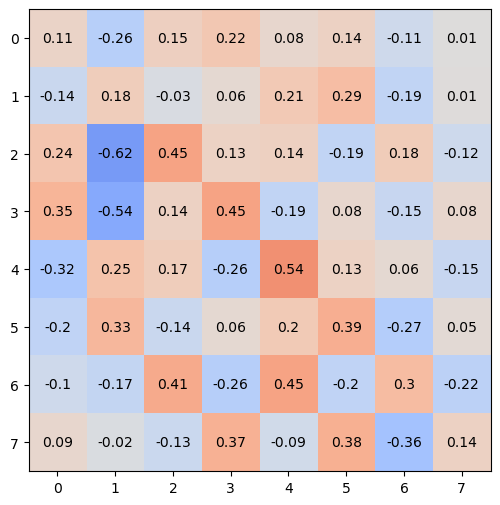

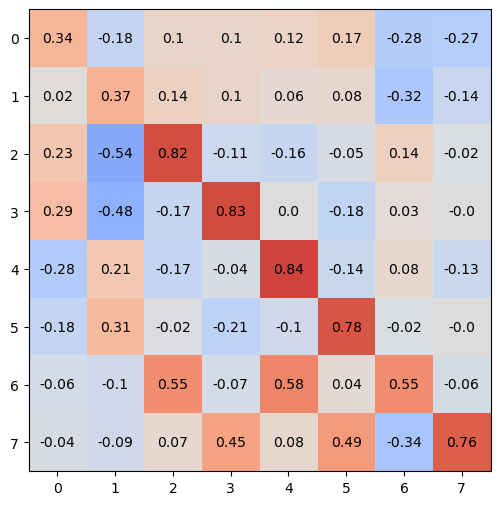

In [102]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(Q.T @ w @ Q, cmap='coolwarm', vmin = -1, vmax = 1)
for (i,j), z in np.ndenumerate(Q.T @ w @ Q):
    if z != 0:
        if z >= -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
        if z < -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
plt.show()


w_rec_bar = np.round(Q.T @ W_rec @ Q, 3)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(w_rec_bar, cmap='coolwarm', vmin = -1, vmax = 1)
for (i,j), z in np.ndenumerate(w_rec_bar):
    if z != 0:
        if z >= -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
        if z < -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
plt.show()

In [76]:
delta_w = np.zeros((8, 8))
delta_w[2, 1] = 1
delta_w[3, 1] = 1
delta_W = 1 * Q @ delta_w @ Q.T  # add more excitation

In [82]:
np.min(delta_W)

0.3652913570404053

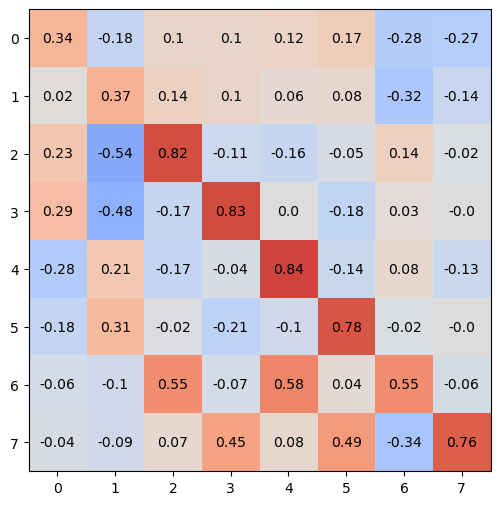

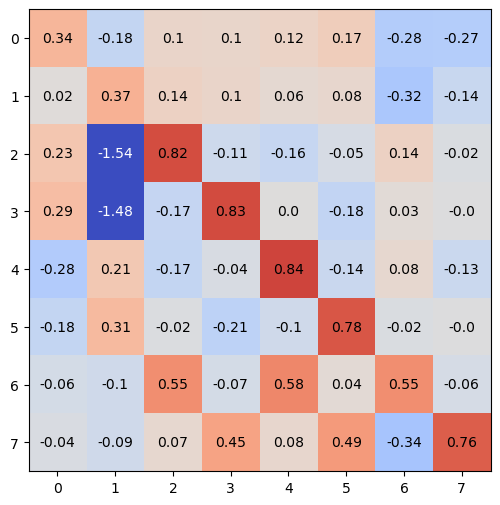

In [53]:
w_rec_bar = np.round(Q.T @ W_rec @ Q, 3)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(w_rec_bar, cmap='coolwarm', vmin = -1, vmax = 1)
for (i,j), z in np.ndenumerate(w_rec_bar):
    if z != 0:
        if z >= -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
        if z < -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
plt.show()


w_rec_bar_corrupted = np.round(Q.T @ (W_rec - delta_W) @ Q, 3)
fig, ax = plt.subplots(1, 1, figsize=(6,6))
ax.imshow(w_rec_bar_corrupted, cmap='coolwarm', vmin = -1, vmax = 1)
for (i,j), z in np.ndenumerate(w_rec_bar_corrupted):
    if z != 0:
        if z >= -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='k')
        if z < -1:
            ax.text(j, i, str(np.round(z, 2)), ha="center", va="center", color='w')
plt.show()

In [67]:
task = TaskCDDM(n_steps=n_steps, n_inputs=input_size, n_outputs=output_size, task_params=task_params)
seed = np.random.randint(1000000)
print(f"seed: {seed}")
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
rng = torch.Generator(device=torch.device(device))
if not seed is None:
    rng.manual_seed(seed)

    
if activation == 'relu':
    activation_RNN = lambda x: torch.maximum(x, torch.tensor(0))
elif activation == 'tanh':
    activation_RNN = torch.tanh
elif activation == 'sigmoid':
    activation_RNN = lambda x: 1/(1 + torch.exp(-x))
elif activation == 'softplus':
    activation_RNN = lambda x: torch.log(1 + torch.exp(5 * x))
    
RNN = RNN_torch(N=W_rec.shape[0], dt=dt, tau=tau, input_size=input_size, output_size=output_size,
                activation=activation_RNN, random_generator=rng, device=device,
                sigma_rec=sigma_rec, sigma_inp=sigma_inp)
RNN_params = {"W_inp": W_inp,
              "W_rec": W_rec,
              "W_out": W_out,
              "b_rec": None,
              "y_init": np.zeros(W_rec.shape[0])}
RNN.set_params(RNN_params)

seed: 591365
Using cpu for RNN!


/Users/tolmach/Documents/GitHub/latent_circuit_inference/jupyter/../../rnn_coach/src/RNN_torch.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tnsr = torch.normal(torch.tensor(mean).to(device), torch.tensor(std).to(device),


In [68]:
input_batch, target_batch, conditions_batch = task.get_batch()
n_trials = len(conditions_batch)
RNN.sigma_rec = RNN.sigma_inp = torch.tensor(0, device=RNN.device)
y, predicted_output_rnn = RNN(torch.from_numpy(input_batch.astype("float32")))
Y = np.hstack([y.detach().numpy()[:, :, i] for i in range(y.shape[-1])])

In [69]:
q_variables = np.einsum("ij,jkl->ikl", Q.T, y.detach().numpy())

In [70]:
# removing silent neurons and z-scoring the responses
Y_mean = np.mean(np.abs(Y.T), axis=0)
inds_fr = np.where(Y_mean > 0)[0]
Y = Y[inds_fr, :]
Z = zscore(Y, axis = 1)
z = Z.reshape(-1, n_trials, n_steps)
z = np.swapaxes(z, 1, 2)

In [71]:
# PCA on Z
pca = PCA(n_components=12)
pca.fit(Z.T)
PCs = pca.components_
D = PCs.T @ PCs
Z_pca = D @ Z
z_pca = Z_pca.reshape(-1, n_trials, n_steps)
z_pca = np.swapaxes(z_pca, 1, 2)

In [72]:
context = np.array([(1 if conditions_batch[i]['context']=='motion' else -1) for i in range(len(conditions_batch))])
motion_coh = np.array([conditions_batch[i]['motion_coh'] for i in range(len(conditions_batch))])
color_coh = np.array([conditions_batch[i]['color_coh'] for i in range(len(conditions_batch))])
choice = np.array([conditions_batch[i]['correct_choice'] for i in range(len(conditions_batch))])

In [73]:
F = np.hstack([context.reshape(-1, 1),
               motion_coh.reshape(-1, 1),
               color_coh.reshape(-1, 1),
               choice.reshape(-1, 1),
               np.ones((n_trials, 1))])
B = np.zeros((Z.shape[0], n_steps, F.shape[1]))
for i in range(Z.shape[0]):
    for t in range(n_steps):
        betas_i_t = lsqr(F, z_pca[i, t, :], damp=0)[0]
        B[i, t, :] = deepcopy(betas_i_t)
ind_cont = np.argmax(np.linalg.norm(B[:, :, 0], axis=0))
ind_motion = np.argmax(np.linalg.norm(B[:, :, 1], axis=0))
ind_color = np.argmax(np.linalg.norm(B[:, :, 2], axis=0))
ind_choice = np.argmax(np.linalg.norm(B[:, :, 3], axis=0))
context_direction = B[:, ind_cont, 0]
motion_direction = B[:, ind_motion, 1]
color_direction = B[:, ind_color, 2]
choice_direction = B[:, ind_choice, 3]
B_max = np.hstack([context_direction.reshape(-1, 1),
                   motion_direction.reshape(-1, 1),
                   color_direction.reshape(-1, 1),
                   choice_direction.reshape(-1,1)])

In [74]:
B_orth, R = np.linalg.qr(B_max)

/var/folders/xg/zhs696691j905z_h1c8w8wvh0000gp/T/ipykernel_52961/4205993036.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(["0", "ctx m", "ctx c", "mR", "mL", "cR", "cL", "Out R", "Out L"])
/var/folders/xg/zhs696691j905z_h1c8w8wvh0000gp/T/ipykernel_52961/4205993036.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(["0", "context", "motion", "color", "choice"])


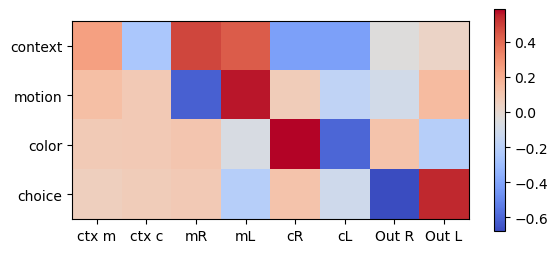

In [75]:
fig, ax = plt.subplots()
try:
    img = ax.imshow(np.round(B_orth.T @ Q[inds_fr, :], 3), cmap = 'coolwarm')
except:
    img = ax.imshow(np.round(B_orth.T @ Q, 3), cmap = 'coolwarm')
fig.colorbar(img, ax=ax, location='right', anchor=(0, 0.5), shrink=0.6)
ax.set_xticklabels(["0", "ctx m", "ctx c", "mR", "mL", "cR", "cL", "Out R", "Out L"])
ax.set_yticklabels(["0", "context", "motion", "color", "choice"])
# ax.set_yticklabels(["0", "context", "mR", "mL", "cR", "cL", "choice"])
plt.show()

# print(np.round(B_orth.T @ Q[inds_fr, :], 2))

In [76]:
# fig = plt.plot(figsize=(8,3))
# plt.stem(B_orth[:, 1], label='TDR motion', markerfmt='r')
# plt.stem(Q[:, 3] - Q[:, 2], label='LCA motion', markerfmt='b')
# th = np.percentile(B_orth[:, 1], 90)
# inds_TDR_motion = np.where(B_orth[:, 1]> th)
# plt.axhline(th, linestyle = '--', color='k')
# plt.legend()
# plt.show()


# fig = plt.plot(figsize=(8,3))
# plt.stem(B_orth[:, 2], label='TDR color', markerfmt='r')
# plt.stem(Q[:, 5] - Q[:, 4], label='LCA color', markerfmt='b')
# th = np.percentile(B_orth[:, 1], 90)
# inds_TDR_color = np.where(B_orth[:, 2]> th)
# plt.axhline(th, linestyle = '--', color='k')
# plt.legend()
# plt.show()

# inds_TDR_motion = inds_TDR_motion[0].tolist()
# inds_TDR_color = inds_TDR_color[0].tolist()

In [77]:
# find 10 neurons such that, removing them from beta directions would result in suppression
num_nrns = 10
values_motion = []
values_color = []
for j in range(B_orth.shape[0]):
    list_indices = np.arange(B_orth.shape[0]).tolist()
    del list_indices[j]
    
    motion_info_TDR_residual = (B_orth[list_indices, 1].reshape(1, -1) @ Z_pca[list_indices, :]).reshape(n_trials, n_steps).T
    inertia_motion_irrelevant = (np.sum(motion_info_TDR_residual[-1, 225:]**2))
    inertia_motion_relevant = (np.sum(motion_info_TDR_residual[-1, :225]**2))
    values_motion.append(inertia_motion_irrelevant)
    
    color_info_TDR_residual = (B_orth[list_indices, 2].reshape(1, -1) @ Z_pca[list_indices, :]).reshape(n_trials, n_steps).T
    inertia_color_irrelevant = (np.sum(color_info_TDR_residual[-1, :225]**2))
    inertia_color_relevant = (np.sum(color_info_TDR_residual[-1, 225:]**2))
    values_color.append(inertia_color_irrelevant)
    
res_motion = sorted(zip(values_motion, range(len(values_motion))), key = lambda x: x[0])
res_color = sorted(zip(values_color, range(len(values_color))), key = lambda x: x[0])

nonspecific_neurons_motion = [res_motion[i][1] for i in range(num_nrns)]
specific_neurons_motion = [res_motion[::-1][i][1] for i in range(num_nrns)]
nonspecific_neurons_color = [res_color[i][1] for i in range(num_nrns)]
specific_neurons_color = [res_color[::-1][i][1] for i in range(num_nrns)]

nonspecific_neurons_motion.sort()
nonspecific_neurons_color.sort()
nrns_to_have_motion = np.arange(B_orth.shape[0]).tolist()
for i in nonspecific_neurons_motion[::-1]:
    del nrns_to_have_motion[i]
    
nrns_to_have_color = np.arange(B_orth.shape[0]).tolist()
for i in nonspecific_neurons_color[::-1]:
    del nrns_to_have_color[i]

In [78]:
print(nonspecific_neurons_motion)
print(nonspecific_neurons_color)

[13, 14, 30, 35, 40, 55, 68, 75, 76, 88]
[5, 6, 23, 43, 49, 70, 73, 74, 78, 88]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


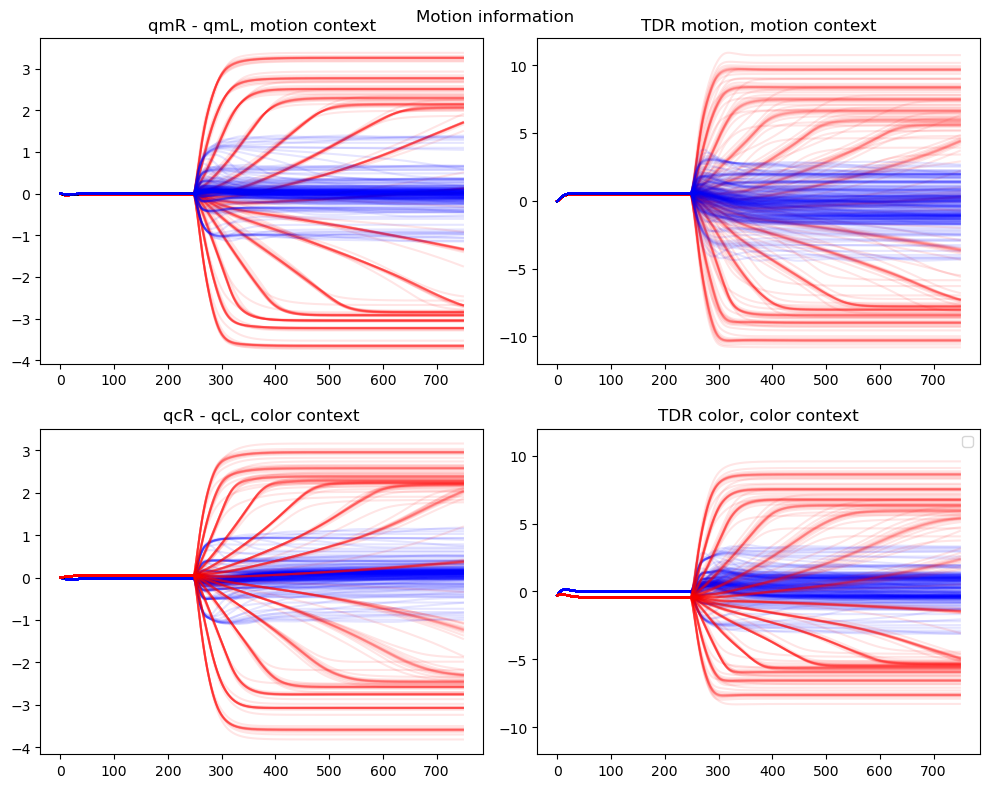

In [79]:
nrns_to_have = nrns_to_have_color
Vars = (B_orth.T[:, nrns_to_have] @ Z_pca[nrns_to_have, :]).reshape(-1, n_trials, n_steps)
Vars = np.swapaxes(Vars, 1, 2)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
plt.suptitle("Motion information")
ax[0, 0].plot(q_variables[3, :, :225] - q_variables[2, :, :225], color='r', alpha=0.1)
ax[0, 0].plot(q_variables[3, :, 225:] - q_variables[2, :, 225:], color='b', alpha=0.1)
ax[0, 1].plot(Vars[1, :, :225], color='r', alpha=0.1, label = 'relevant')
ax[0, 1].plot(Vars[1, :, 225:], color='b', alpha=0.1, label = 'irrelevant')
ax[0, 1].set_ylim([-12, 12])

ax[1, 0].plot(q_variables[5, :, :225] - q_variables[4, :, :225], color='b', alpha=0.1, label = 'irrelevant')
ax[1, 0].plot(q_variables[5, :, 225:] - q_variables[4, :, 225:], color='r', alpha=0.1, label = 'relevant')
ax[1, 1].plot(Vars[2, :, :225], color='b', alpha=0.1)
ax[1, 1].plot(Vars[2, :, 225:], color='r', alpha=0.1)
ax[1, 1].set_ylim([-12, 12])
plt.legend()
plt.tight_layout()
plt.subplots_adjust(hspace=0.2)
ax[0, 0].title.set_text('qmR - qmL, motion context')
ax[0, 1].title.set_text('TDR motion, motion context')
ax[1, 0].title.set_text('qcR - qcL, color context')
ax[1, 1].title.set_text('TDR color, color context')
plt.show()

In [80]:
# fig = plt.figure(figsize =(8, 3))
# plt.hist(Vars[1, 250:, :225].flatten().T, bins=200, alpha = 0.5, label = 'relevant')
# plt.hist(Vars[1, 250:, 225:].flatten().T, bins=200, alpha = 0.5, label = 'irrelevant')
# plt.legend()
# plt.show()

In [81]:
# v1 = B_orth[:, 2]
# v2 = Q[inds_fr, 4]
# v3 = Q[inds_fr, 5]
# v4 = Q[inds_fr, 4] - Q[inds_fr, 5]
# arr = np.hstack([v1.reshape(-1, 1),
#                  v2.reshape(-1, 1),
#                  v3.reshape(-1, 1),
#                  v4.reshape(-1, 1),
#                  np.arange(len(v1)).reshape(-1, 1)])
# arr_sorted = arr[np.abs(arr[:,0]).argsort()]
# y_np = y.detach().numpy()[inds_fr, :, :]

# ind_start = 50
# fig = plt.figure(figsize = (15, 3))
# plt.stem(np.arange(len(v1))[ind_start:],arr_sorted[ind_start:, 0], markerfmt='r')
# plt.stem(np.arange(len(v1))[ind_start:],arr_sorted[ind_start:, 1], markerfmt='g')
# plt.stem(np.arange(len(v1))[ind_start:],arr_sorted[ind_start:, 2], markerfmt='lightgreen')
# # plt.stem(np.abs(arr_sorted[:, 3]), markerfmt='b')
# plt.xticks(np.arange(len(v1))[ind_start:], rotation=70, size=8)
# plt.grid(True)
# plt.show()

0.072550565 0.07399968
0.12715323 0.018038226
0.1174982 0.2897783
0.1767181 0.010663338
0.31161383 0.12997569
0.35395905 0.0


/Users/tolmach/miniconda3/envs/gpu_env/lib/python3.10/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


0.3233632 0.0
0.23013255 4.937125e-08
0.28468728 0.0
0.12126599 6.359625e-06


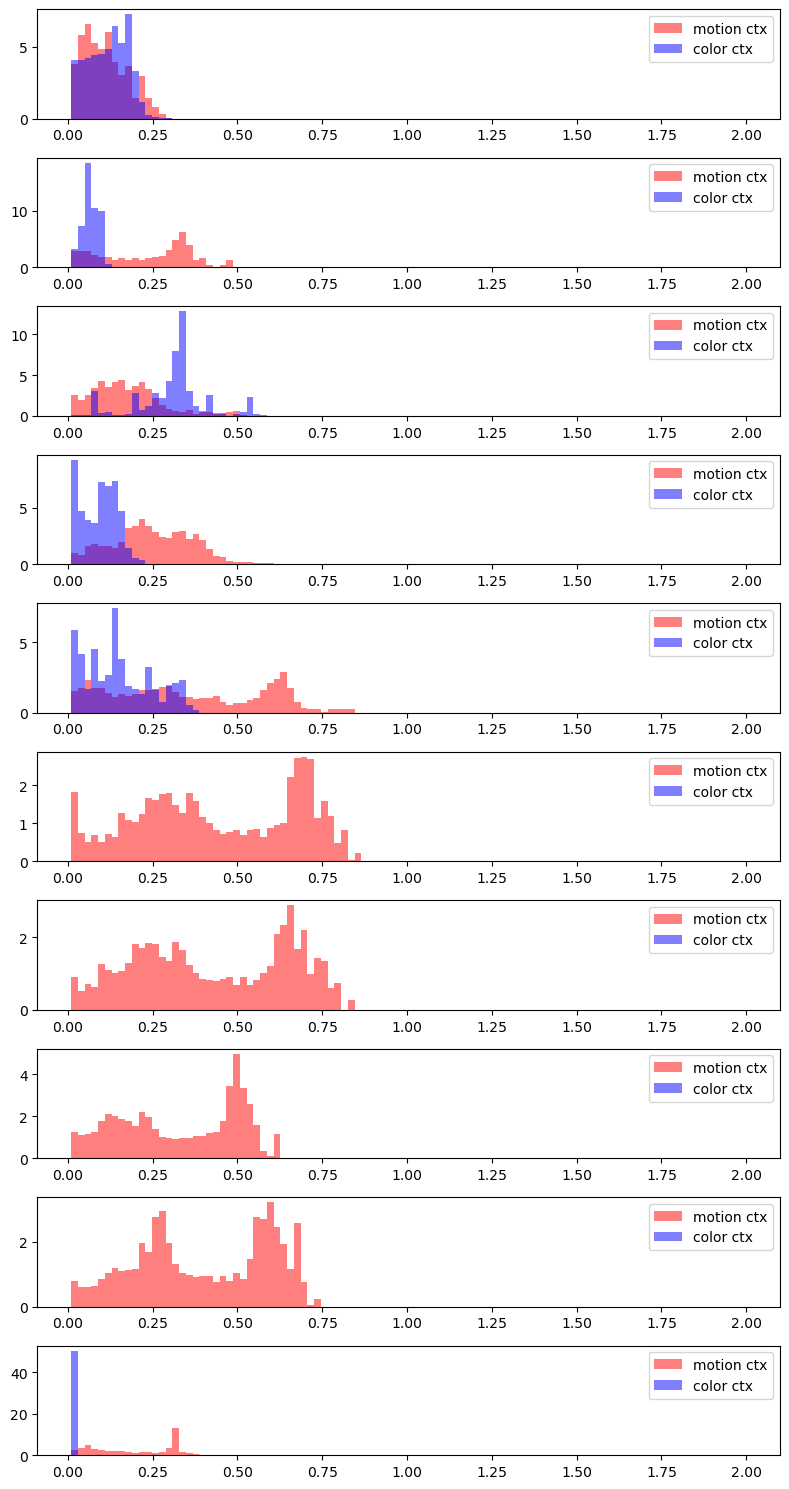

In [82]:
y_np = y.detach().numpy()[inds_fr, :, :]
fig, ax = plt.subplots(len(specific_neurons_color), figsize = (8, 1.5 * len(nonspecific_neurons_color)))
for n, i in enumerate(specific_neurons_color):
    i = int(i)
    neural_traces = y_np[i, :, :]

    ax[n].hist(neural_traces[250:, :225].flatten(), color='r', alpha = 0.5, range=[0.01, 2], density=True, bins = 100, label = "motion ctx")
    ax[n].hist(neural_traces[250:, 225:].flatten(), color='b', alpha = 0.5, range=[0.01, 2], density=True, bins = 100, label = "color ctx")
    ax[n].legend(loc = 1)
    print(np.mean(neural_traces[250:, :225]), np.mean(neural_traces[250:, 225:]))
    plt.tight_layout()
plt.show()

In [83]:
print(np.round(Q[inds_fr, 4][nonspecific_neurons_color],3))
print(np.round(Q[inds_fr, 4][specific_neurons_color], 3))

[-0.132  0.172 -0.048 -0.024 -0.058 -0.02   0.09  -0.011 -0.085  0.079]
[ 0.007 -0.009 -0.035 -0.015 -0.04   0.038  0.026  0.019 -0.003 -0.059]


In [84]:
print(np.mean((Q[inds_fr, 4][nonspecific_neurons_color] - Q[inds_fr, 5][nonspecific_neurons_color])**2))
print(np.mean((Q[inds_fr, 4][specific_neurons_color] - Q[inds_fr, 5][specific_neurons_color])**2))

0.020518048564245318
0.0239087824451998
